# Sections:
- Load Data
- EDA
- Rating Prediction
    - Baseline Mean Predictor
    - Latent Factor: Bias only
    - Complete Latent Factor
    - FastFM with no features
    - FASTFM with features
    - Probabilistic Matrix Factorization
    - Linear Regression
    - Random Forest
    - KNN
    - SVR

In [4]:
# standard
import gzip
import json
from collections import defaultdict
import random
import math
import time 
from datetime import datetime

# data and modeling
import pandas as pd
import numpy as np
import tensorflow as tf

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Load Data
**Download review and places data from [here](https://cseweb.ucsd.edu/~jmcauley/datasets.html#google_local) and put in data directory under same folder as this notebook.**


In [4]:
# load places data as dict

data_places = defaultdict(dict)  # gPlusPlaceId: name, price, hours, closed, gps

f = gzip.open("data/places.clean.json.gz")
for l in f:
    place = eval(l)
    
    if not place['gps']: continue
    lat, lon = place['gps']
    if not (-90 <= lat <= 90 and -180 <= lon <= 180): continue
    if not place['address']: continue
        
    data_places[place['gPlusPlaceId']] = {'name': place['name'],
                                          'address': place['address'],
                                          'price': place['price'],
                                          'hours': place['hours'],
                                          'closed': place['closed'],
                                          'gps': place['gps']
                                         }

In [9]:
# # if you save above as json file "data/places.json" for future runs, read places.json below:
# with open("data/places.json", "r") as f:
#     data_places = json.load(f)

In [3]:
# initial check
len(data_places)
data_places

{'104699454385822125632': {'name': 'Diamond Valley Lake Marina',
  'address': ['2615 Angler Ave', 'Hemet, CA 92545'],
  'price': None,
  'hours': [['Monday', [['6:30 am--4:15 pm']]],
   ['Tuesday', [['6:30 am--4:15 pm']]],
   ['Wednesday', [['6:30 am--4:15 pm']], 1],
   ['Thursday', [['6:30 am--4:15 pm']]],
   ['Friday', [['6:30 am--4:15 pm']]],
   ['Saturday', [['6:30 am--4:15 pm']]],
   ['Sunday', [['6:30 am--4:15 pm']]]],
  'closed': False,
  'gps': [33.703804, -117.003209]},
 '103054478949000078829': {'name': 'Blue Ribbon Cleaners',
  'address': ['Parole', 'Annapolis, MD'],
  'price': None,
  'hours': None,
  'closed': False,
  'gps': [38.979759, -76.547538]},
 '109810290098030327104': {'name': 'Portofino',
  'address': ['ул. Тутаева, 1', 'Nazran, Ingushetia, Russia', '366720'],
  'price': None,
  'hours': [['Monday', [['9:30 am--9:00 pm']]],
   ['Tuesday', [['9:30 am--9:00 pm']]],
   ['Wednesday', [['9:30 am--9:00 pm']], 1],
   ['Thursday', [['9:30 am--9:00 pm']]],
   ['Friday', [

In [8]:
# load review data, keep only reviews from USA states

data_reviews = []

f = gzip.open("data/reviews.clean.json.gz")
for i, l in enumerate(f):
    if i >= 2e6:
        break
    
    # if review in California, add to dataset
    review = eval(l)
    place = review['gPlusPlaceId']
    if place in data_places:
        address = data_places[place]['address']
        state = address[-1].split(', ')[-1].split(' ')[0]
        if state == 'CA':
            data_reviews.append(review)

In [5]:
# # if you save above as json file "data/reviews.json" for future runs, read below:
# with open("data/reviews.json", "r") as f:
#     data_reviews = json.load(f)

In [6]:
# initial check
len(data_reviews)

133924

In [6]:
data_reviews[0]

{'rating': 4.0,
 'reviewerName': 'william spindler',
 'reviewText': 'Best War Wanton soup in Red Bluff',
 'categories': ['Asian Restaurant', 'Chinese Restaurant'],
 'gPlusPlaceId': '106591714648856494903',
 'unixReviewTime': 1394669496,
 'reviewTime': 'Mar 12, 2014',
 'gPlusUserId': '100000032416892623125'}

In [7]:
data_places[data_reviews[0]['gPlusPlaceId']]

{'name': 'Peking Chinese Restaurant',
 'address': ['860 Main St', 'Red Bluff, CA 96080'],
 'price': '$$$',
 'hours': [['Monday', [['11:00 am--8:30 pm']]],
  ['Tuesday', [['11:00 am--8:30 pm']]],
  ['Wednesday', [['11:00 am--8:30 pm']], 1],
  ['Thursday', [['11:00 am--8:30 pm']]],
  ['Friday', [['11:00 am--8:30 pm']]],
  ['Saturday', [['12:00--8:30 pm']]],
  ['Sunday', [['12:00--8:30 pm']]]],
 'closed': False,
 'gps': [40.179159, -122.236162]}

# EDA

In [7]:
# ratings per user & ratings per place

ratingsPerUser = defaultdict(list)
ratingsPerPlace = defaultdict(list)

for review in data_reviews:
    user = review['gPlusUserId']
    place = review['gPlusPlaceId']
    rating = review['rating']
    ratingsPerUser[user].append((place, rating))
    ratingsPerPlace[place].append((user, rating))

Num users: 57821
Avg num of ratings per user:  2.32
Quantiles:  [  1.   1.   1.   2. 514.]


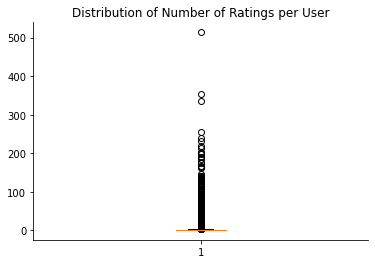

In [9]:
# How many users? Avg number of ratings per user? Quantiles of ratings per user?

num_users = len(ratingsPerUser)
print(f"Num users: {num_users}")

num_ratings_per_user = [len(user_ratings) for user_ratings in ratingsPerUser.values()]
avg_num_ratings_per_user = np.mean(num_ratings_per_user)
print(f"Avg num of ratings per user: {avg_num_ratings_per_user: .2f}")

print("Quantiles: ", np.quantile(num_ratings_per_user, [0, .25, .5, .75, 1]))

plt.boxplot(num_ratings_per_user)
plt.title('Distribution of Number of Ratings per User');

In [10]:
# Avg rating? Quantiles of ratings?
all_ratings = [review['rating'] for review in data_reviews]
print(f"Avg rating: {np.mean(all_ratings): .2f}")
print("Quantiles: ", np.quantile(all_ratings, [0, .25, .5, .75, 1]))

Avg rating:  4.09
Quantiles:  [0. 4. 5. 5. 5.]


Num places: 70644
Avg num of ratings per place:  1.90
Quantiles:  [ 1.  1.  1.  2. 89.]


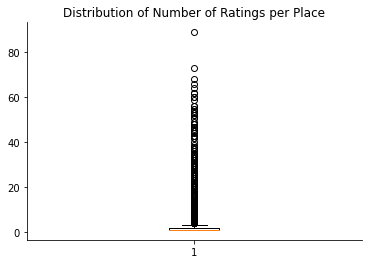

In [11]:
# How many places? Avg number of ratings per place? Quantiles of ratings per place?

num_places = len(ratingsPerPlace)
print(f"Num places: {num_places}")

num_ratings_per_place = [len(place_ratings) for place_ratings in ratingsPerPlace.values()]
avg_num_ratings_per_place = np.mean(num_ratings_per_place)
print(f"Avg num of ratings per place: {avg_num_ratings_per_place: .2f}")

print("Quantiles: ", np.quantile(num_ratings_per_place, [0, .25, .5, .75, 1]))

plt.boxplot(num_ratings_per_place)
plt.title('Distribution of Number of Ratings per Place');

Quantile:  [1.0000e+00 2.0000e+00 9.0000e+00 4.3000e+01 1.0248e+04]
Proportion of categories with above 10 ratings:  0.47575057736720555


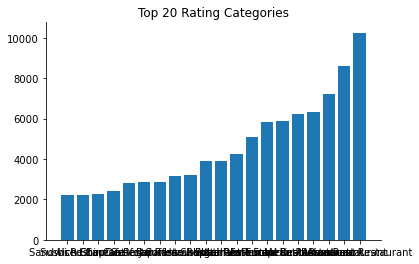

In [12]:
# Most popular categories for reviews?

# frequency of categories for reviews
categories = defaultdict(int)
for review in data_reviews:
    cats = review['categories']
    if cats:
        for cat in cats:
            categories[cat] += 1     
            
# stats for categories
sorted_cats = sorted(categories, key=categories.get)
sorted_cats_vals = [categories[cat] for cat in sorted_cats] 

print("Quantile: ", np.quantile(sorted_cats_vals, [0, .25, .5, .75, 1]))
print("Proportion of categories with above 10 ratings: ", np.sum(np.array(sorted_cats_vals) > 10) / len(categories))

# Top Categories
plt.bar(sorted_cats[-20:], sorted_cats_vals[-20:])
plt.title('Top 20 Rating Categories');

In [13]:
print(sorted_cats[-20:])

['Sandwich Shop', 'Sushi Restaurant', 'Used Car Dealer', 'Cafe', 'Chinese Restaurant', 'Bar', 'Seafood Restaurant', 'Coffee Shop', 'Japanese Restaurant', 'Hotel', 'Hamburger Restaurant', 'Pizza Restaurant', 'Italian Restaurant', 'Latin American Restaurant', 'Fast Food Restaurant', 'European Restaurant', 'Mexican Restaurant', 'Restaurant', 'Asian Restaurant', 'American Restaurant']


In [10]:
# Where are the reviews?

latitudes = []
longitudes = []
addresses = []

for review in data_reviews:
    place = review['gPlusPlaceId']
    if place in data_places:
        lat, lon = data_places[place]['gps']
        latitudes.append(lat)
        longitudes.append(lon)
        addresses.append(data_places[place]['address'])
        
# fig = px.scatter_geo(lat=latitudes, lon=longitudes, hover_name=addresses)
# fig.update_layout(title='Location of Places', geo_scope='usa')

In [11]:
# filter for users with 5+ ratings

users_filt = set()  # users with 5+ ratings
for user, ratings in ratingsPerUser.items():
    if len(ratings) >= 5:
        users_filt.add(user)

data_reviews_filt = []  # filtered for users with 5+ ratings
for review in data_reviews:
    if review['gPlusUserId'] in users_filt:
        data_reviews_filt.append(review)
        
ratingsPerUser_filt = defaultdict(list)
ratingsPerPlace_filt = defaultdict(list)

for review in data_reviews_filt:
    user = review['gPlusUserId']
    place = review['gPlusPlaceId']
    rating = review['rating']
    ratingsPerUser_filt[user].append((place, rating))
    ratingsPerPlace_filt[place].append((user, rating))

Num users: 4460
Avg num of ratings per user:  13.98
Quantiles:  [  5.   6.   8.  13. 514.]


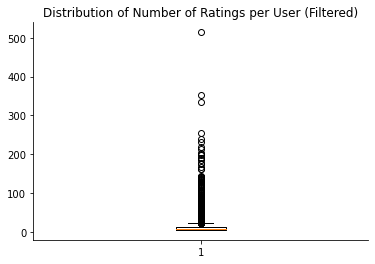

In [17]:
# After filtering:
# How many users? Avg number of ratings per user? Quantiles of ratings per user?

num_users_filt = len(ratingsPerUser_filt)
print(f"Num users: {num_users_filt}")

num_ratings_per_user_filt = [len(user_ratings) for user_ratings in ratingsPerUser_filt.values()]
avg_num_ratings_per_user_filt = np.mean(num_ratings_per_user_filt)
print(f"Avg num of ratings per user: {avg_num_ratings_per_user_filt: .2f}")

print("Quantiles: ", np.quantile(num_ratings_per_user_filt, [0, .25, .5, .75, 1]))

plt.boxplot(num_ratings_per_user_filt)
plt.title('Distribution of Number of Ratings per User (Filtered)');

Num places: 36444
Avg num of ratings per place:  1.71
Quantiles:  [ 1.  1.  1.  2. 53.]


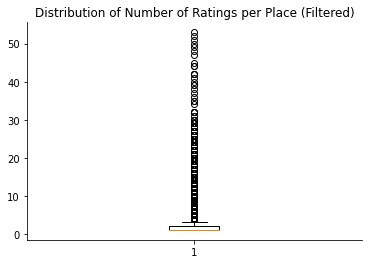

In [18]:
# After filtering:
# How many places? Avg number of ratings per place? Quantiles of ratings per place?

num_places_filt = len(ratingsPerPlace_filt)
print(f"Num places: {num_places_filt}")

num_ratings_per_place_filt = [len(place_ratings) for place_ratings in ratingsPerPlace_filt.values()]
avg_num_ratings_per_place_filt = np.mean(num_ratings_per_place_filt)
print(f"Avg num of ratings per place: {avg_num_ratings_per_place_filt: .2f}")

print("Quantiles: ", np.quantile(num_ratings_per_place_filt, [0, .25, .5, .75, 1]))

plt.boxplot(num_ratings_per_place_filt)
plt.title('Distribution of Number of Ratings per Place (Filtered)');

In [12]:
# Where are the reviews?

latitudes = []
longitudes = []
names = []

for review in data_reviews_filt:
    place = review['gPlusPlaceId']
    if place in data_places:
        lat, lon = data_places[place]['gps']
        latitudes.append(lat)
        longitudes.append(lon)
        names.append(data_places[place]['name'])
        
# fig = px.scatter_geo(lat=latitudes, lon=longitudes, hover_name=names)
# fig.update_layout(title='Location of Places (Filtered)', geo_scope='usa')

In [20]:
# make table for rating, year, month, hour
df_time = pd.DataFrame(columns=['rating', 'year', 'month', 'hour'])
for review in data_reviews_filt:
    if review['unixReviewTime']:
        rating = review['rating']
        year = datetime.utcfromtimestamp(review['unixReviewTime']).year
        month = datetime.utcfromtimestamp(review['unixReviewTime']).month
        hour = datetime.utcfromtimestamp(review['unixReviewTime']).hour

        df_time.loc[len(df_time)]  = [rating, int(year), int(month), int(hour)]
        
df_time.year = df_time.year.apply(lambda yr: int(yr))
df_time.month = df_time.month.apply(lambda m: int(m))
df_time.hour = df_time.hour.apply(lambda hr: int(hr))

df_time.head()

,rating,year,month,hour
0,4.0,2014,3,0
1,5.0,2014,3,19
2,5.0,2014,3,0
3,4.0,2014,3,0
4,5.0,2014,3,0


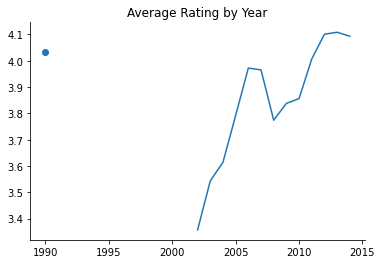

In [21]:
# average rating by year?
plt.plot(df_time.groupby('year')['rating'].mean()[1:])
plt.scatter(1990, df_time.groupby('year')['rating'].mean().iloc[0])
plt.title('Average Rating by Year');

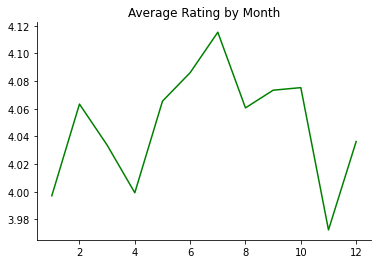

In [22]:
# average rating by month
plt.plot(df_time.groupby('month')['rating'].mean(), color='green')
plt.title('Average Rating by Month');

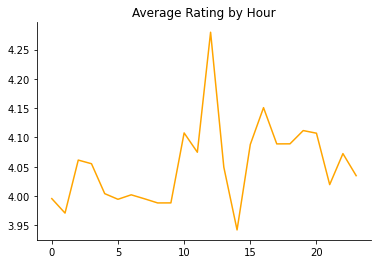

In [23]:
# average rating by hour
plt.plot(df_time.groupby('hour')['rating'].mean(), color='orange')
plt.title('Average Rating by Hour');

Avg rating:  4.04
Quantiles:  [0. 3. 4. 5. 5.]


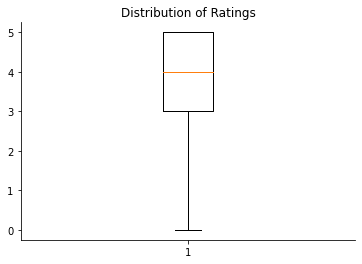

In [24]:
# overall rating distribution?

ratings = [review['rating'] for review in data_reviews_filt]
avg_rating = np.mean(ratings)
print(f"Avg rating: {avg_rating: .2f}")

print("Quantiles: ", np.quantile(ratings, [0, .25, .5, .75, 1]))

plt.boxplot(ratings)
plt.title('Distribution of Ratings');

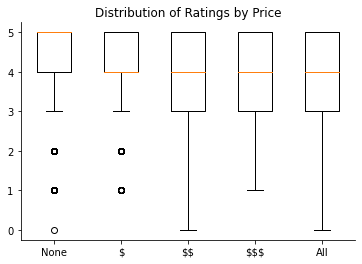

In [25]:
# rating distribution by price?
ratings_none = []
ratings_1 = []
ratings_2 = []
ratings_3 = []

for review in data_reviews_filt:
    price = data_places[review['gPlusPlaceId']]['price']
    rating = review['rating']
    if price is None:
        ratings_none.append(rating)
    elif price == '$':
        ratings_1.append(rating)
    elif price == '$$':
        ratings_2.append(rating)
    elif price == '$$$':
        ratings_3.append(rating)
        
plt.boxplot([ratings_none, ratings_1, ratings_2, ratings_3, ratings], 
            labels=['None', "$", "\\$$", "$$$", "All"])
plt.title('Distribution of Ratings by Price');

# Rating Prediction

In [114]:
def MSE(pred, truth):
    return np.mean([(p - t) ** 2 for p, t in zip(pred, truth)])

In [10]:
len(data_reviews_filt)

62338

In [11]:
data_reviews_filt[0]

{'rating': 4.0,
 'reviewerName': 'william spindler',
 'reviewText': 'Best War Wanton soup in Red Bluff',
 'categories': ['Asian Restaurant', 'Chinese Restaurant'],
 'gPlusPlaceId': '106591714648856494903',
 'unixReviewTime': 1394669496,
 'reviewTime': 'Mar 12, 2014',
 'gPlusUserId': '100000032416892623125'}

In [115]:
# split data
# test: last rating per user
# valid: second to last rating per user
# train: rest of ratings per user

train = []
val = []
test = []

for user, ratings in ratingsPerUser_filt.items():
    for rating in ratings[:-2]:
        train.append([user] + list(rating))
    val.append([user] + list(ratings[-2]))
    test.append([user] + list(ratings[-1]))

In [116]:
# enumerate IDs

userIDs = {}
itemIDs = {}

for review in data_reviews_filt:
    u = review['gPlusUserId']
    i = review['gPlusPlaceId']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
        
nUsers = len(userIDs)
nItems = len(itemIDs)

## Baseline: mean prediction

In [117]:
labels_train = [rating for _, _, rating in train]
mean_rating = np.mean(labels_train)
pred_train = [mean_rating] * len(train)
print('train mse: ', MSE(pred_train, labels_train))

labels_val = [rating for _, _, rating in val]
pred_val = [mean_rating] * len(val)
print('val mse: ', MSE(pred_val, labels_val))

labels_test = [rating for _, _, rating in test]
pred_test = [mean_rating] * len(test)
print('test mse: ', MSE(pred_test, labels_test))

train mse:  1.1080448861340293
val mse:  1.2982834085054054
test mse:  1.2788264964653766


## Latent Factor Model: Bias Only

In [118]:
class LatentFactorModelBiasOnly(tf.keras.Model):
    def __init__(self, mu, lamb):
        super(LatentFactorModelBiasOnly, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu, dtype=tf.float32)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i]
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        pred = self.alpha + beta_u + beta_i
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [119]:
def trainingStepBiasOnly(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
        (grad, var) in zip(gradients, model.trainable_variables)
        if grad is not None)
    return loss.numpy()

In [17]:
minMSE = float('inf')
best_lr = None
best_lamb = None
best_model = None
labels_val = [review[2] for review in val]

for lr in (.001, .01, .1):
    for lamb in (1e-4, 1e-3, 1e-2, 1e-1, 1):       
        # initialize optimizer and model
        optimizer = tf.keras.optimizers.Adam(lr)
        modelBiasOnly = LatentFactorModelBiasOnly(mean_rating, lamb)

        # training
        for i in range(50):
            obj = trainingStepBiasOnly(modelBiasOnly, train)

        # predict on validation set
        pred =\
            [modelBiasOnly.predict(userIDs[u],itemIDs[i]).numpy() for u,i,_ in val]
        pred = np.array(pred)
        pred = np.where(pred < 0, 0, pred)  # min bound = 0
        pred = np.where(pred > 5, 5, pred)  # max bound = 5

        # error
        mse = MSE(pred, labels_val)
        if mse < minMSE:
                minMSE = mse
                best_lr = lr
                best_lamb = lamb
                best_model = modelBiasOnly

        print(f'lr = {lr}, lamb = {lamb}: validation MSE = {mse}')
        
print(f'\nThe best model has: lr = {best_lr}, lambda = {best_lamb}, validation mse = {minMSE}')

lr = 0.001, lamb = 0.0001: validation MSE = 1.2650389963014863
lr = 0.001, lamb = 0.001: validation MSE = 1.2730475318090104
lr = 0.001, lamb = 0.01: validation MSE = 1.2924325979546616
lr = 0.001, lamb = 0.1: validation MSE = 1.2975919364997888
lr = 0.001, lamb = 1: validation MSE = 1.2978640738589795
lr = 0.01, lamb = 0.0001: validation MSE = 1.137547834253309
lr = 0.01, lamb = 0.001: validation MSE = 1.250376417853596
lr = 0.01, lamb = 0.01: validation MSE = 1.2914187428535726
lr = 0.01, lamb = 0.1: validation MSE = 1.2971920037864106
lr = 0.01, lamb = 1: validation MSE = 1.2980280281868537
lr = 0.1, lamb = 0.0001: validation MSE = 1.1168864907512077
lr = 0.1, lamb = 0.001: validation MSE = 1.2493022373298948
lr = 0.1, lamb = 0.01: validation MSE = 1.2899378193582816
lr = 0.1, lamb = 0.1: validation MSE = 1.297489148364969
lr = 0.1, lamb = 1: validation MSE = 1.2989149281461507

The best model has: lr = 0.1, lambda = 0.0001, validation mse = 1.1168864907512077


In [ ]:
# with bounding output
# The best model has: lr = 0.1, lambda = 0.0001, validation mse = 1.1168864907512077

In [120]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelBiasOnly = LatentFactorModelBiasOnly(mean_rating, 0.0001)

# training
for i in range(50):
    obj = trainingStepBiasOnly(modelBiasOnly, train)

# predict on test set
pred =\
    [modelBiasOnly.predict(userIDs[u],itemIDs[i]).numpy() for u,i,_ in test]
pred = np.array(pred)
pred = np.where(pred < 0, 0, pred)  # min bound = 0
pred = np.where(pred > 5, 5, pred)  # max bound = 5

# error
print(MSE(pred, labels_test))

2022-11-30 06:38:41.630482: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-30 06:38:41.630583: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-30 06:38:41.630686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dsmlp-jupyter-svillama): /proc/driver/nvidia/version does not exist
2022-11-30 06:38:41.682990: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1.129109715211232


## Latent Factor Model: Complete

In [121]:
class LatentFactorModel(tf.keras.Model):
    def __init__(self, mu, K, lamb):
        super(LatentFactorModel, self).__init__()
        # Initialize to average
        self.alpha = tf.Variable(mu, dtype=tf.float32)
        # Initialize to small random values
        self.betaU = tf.Variable(tf.random.normal([len(userIDs)],stddev=0.001))
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb

    # Prediction for a single instance (useful for evaluation)
    def predict(self, u, i):
        p = self.alpha + self.betaU[u] + self.betaI[i] +\
            tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p

    # Regularizer
    def reg(self):
        return self.lamb * (tf.reduce_sum(self.betaU**2) +\
                            tf.reduce_sum(self.betaI**2) +\
                            tf.reduce_sum(self.gammaU**2) +\
                            tf.reduce_sum(self.gammaI**2))
    
    # Prediction for a sample of instances
    def predictSample(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_u = tf.nn.embedding_lookup(self.betaU, u)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        pred = self.alpha + beta_u + beta_i +\
               tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return pred
    
    # Loss
    def call(self, sampleU, sampleI, sampleR):
        pred = self.predictSample(sampleU, sampleI)
        r = tf.convert_to_tensor(sampleR, dtype=tf.float32)
        return tf.nn.l2_loss(pred - r) / len(sampleR)

In [122]:
def trainingStep(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleR = [], [], []
        for _ in range(Nsamples):
            u,i,r = random.choice(interactions)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleR.append(r)

        loss = model(sampleU,sampleI,sampleR)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [ ]:
# initialize the model; EXPERIMENT WITH LR, K, and lambda !!!
optimizer = tf.keras.optimizers.Adam(0.01)
modelLFM = LatentFactorModel(mean_rating, 10, 0.0001)

In [ ]:
# run 100 iterations of gradient descent
for i in range(100):
    obj = trainingStep(modelLFM, train)
#     if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

In [ ]:
# prediction
preds_val = []
for u, i, r in val:
    pred = modelLFM.predict(userIDs[u], itemIDs[i]).numpy()
    if pred < 0:
        pred = 0
    elif pred > 5:
        pred = 5
    preds_val.append(pred)

print(MSE(preds_val, labels_val))

In [123]:
optimizer = tf.keras.optimizers.Adam(0.1)
modelLFM = LatentFactorModel(mean_rating, 10, 0.0001)

# training
for i in range(100):
    obj = trainingStep(modelLFM, train)

# predict on test set
pred =\
    [modelLFM.predict(userIDs[u],itemIDs[i]).numpy() for u,i,_ in test]
pred = np.array(pred)
pred = np.where(pred < 0, 0, pred)  # min bound = 0
pred = np.where(pred > 5, 5, pred)  # max bound = 5

# error
print(MSE(pred, labels_test))

1.1178592860281336


## Fast-FM with no features:
- source: https://cseweb.ucsd.edu/~jmcauley/pml/code/chap6.html

In [124]:
import scipy
from fastFM import als

In [125]:
# build factorization machine design matrix

nUsers, nItems = len(userIDs), len(itemIDs)

X = scipy.sparse.lil_matrix((len(data_reviews_filt), nUsers + nItems))
for i, review in enumerate(train + val + test):
    user = userIDs[review[0]]
    item = itemIDs[review[1]]
    X[i, user] = 1 # One-hot encoding of user
    X[i, nUsers + item] = 1 # One-hot encoding of item

# target for each row
y = np.array([review[2] for review in train + val + test])

# split data
X_train, X_val, X_test = X[:len(train)], X[len(train): len(train) + len(val)], X[len(train) + len(val):]
y_train, y_val, y_test = y[:len(train)], y[len(train): len(train) + len(val)], y[len(train) + len(val):]

In [126]:
# initialize factorization machine
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=5, l2_reg_w=0.1, l2_reg_V=0.5)

# train the model
fm.fit(X_train, y_train)

# predict on val set
y_pred = fm.predict(X_val)
MSE(y_pred, y_val)

18.419784051615174

In [56]:
# predict with bounds [0,5]
y_pred = fm.predict(X_val)

y_pred = np.where(y_pred < 0, 0, y_pred)  # min bound = 0
y_pred = np.where(y_pred > 5, 5, y_pred)  # max bound = 5

MSE(y_pred, y_val)

2.045847544706892

In [127]:
# predict with bounds [0,5]
y_pred = fm.predict(X_test)

y_pred = np.where(y_pred < 0, 0, y_pred)  # min bound = 0
y_pred = np.where(y_pred > 5, 5, y_pred)  # max bound = 5

MSE(y_pred, y_test)

2.021857995943468

In [ ]:
def train_ALS(X_train, y_train, X_val, y_val, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on MSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regw = 0
    best_regV = 0
    best_model = None
    for rank in ranks:
        for regw in reg_param:
            for regV in reg_param:
                # train ALS model
                model = als.FMRegression(
                    n_iter=num_iters,
                    init_stdev=0.1,
                    rank=rank,
                    l2_reg_w=regw,
                    l2_reg_V=regV
                )
                model.fit(X_train, y_train)
                
                # predict on validation set
                predictions = model.predict(X_val)
                predictions = np.where(predictions < 0, 0, predictions)  # min bound = 0
                predictions = np.where(predictions > 5, 5, predictions)  # max bound = 5
                
                # get MSE
                error = MSE(predictions, y_val)
                print(f'latent factors = {rank}, regw = {regw}, regV = {regV}: validation MSE is {error}')
                if error < min_error:
                    min_error = error
                    best_rank = rank
                    best_regw = regw
                    best_regV = regV
                    best_model = model
    print(f'\nThe best model has: latent factors = {best_rank}, regw = {best_regw}, regV = {best_regV}')
    return best_model

In [ ]:
# hyper-param config
num_iterations = 100
ranks = [4, 6, 8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(X_train, y_train, X_val, y_val, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
# without bounds:
# The best model has: latent factors = 16, regw = 0.1, regV = 0.01
# validation MSE is 18.041808777232184

# with bounds:
# The best model has: latent factors = 4, regw = 0.001, regV = 0.5
# validation MSE is 1.9614244054984518

In [128]:
# initialize factorization machine
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=4, l2_reg_w=0.001, l2_reg_V=0.5)

# train the model
fm.fit(X_train, y_train)

# predict on test set
y_pred = fm.predict(X_test)
y_pred = np.where(y_pred < 0, 0, y_pred)  # min bound = 0
y_pred = np.where(y_pred > 5, 5, y_pred)  # max bound = 5

MSE(y_pred, y_test)

2.0374384339590716

## Fast-FM with features:
- categories
- year
- month
- hour
- price

In [130]:
data_pair_reviews = defaultdict(dict)

for review in data_reviews_filt:
    user = review['gPlusUserId']
    place = review['gPlusPlaceId']
    data_pair_reviews[(user, place)] = review

In [131]:
# transform categories to one-hot
categoryIDs = {}

for review in data_reviews_filt:
    # categories
    cats = review['categories']
    if cats:
        for cat in cats:
            if not cat in categoryIDs: categoryIDs[cat] = len(categoryIDs)
nCats = len(categoryIDs)

In [132]:
# transform years to one-hot
years = [review['reviewTime'][-4:] if review['reviewTime'] else -1 for review in data_reviews_filt]
yearIDs = {k:v for k, v in zip(np.unique(years)[1:], range(len(np.unique(years)[1:])))}
nYears = len(yearIDs)

yearIDs

{'1990': 0,
 '2002': 1,
 '2003': 2,
 '2004': 3,
 '2005': 4,
 '2006': 5,
 '2007': 6,
 '2008': 7,
 '2009': 8,
 '2010': 9,
 '2011': 10,
 '2012': 11,
 '2013': 12,
 '2014': 13}

In [133]:
# transform month to one-hot
months = [review['reviewTime'][:3] if review['reviewTime'] else -1 for review in data_reviews_filt]
monthIDs = {k:v for k, v in zip(np.unique(months)[1:], range(len(np.unique(months)[1:])))}
nMonths = len(monthIDs)

monthIDs

{'Apr': 0,
 'Aug': 1,
 'Dec': 2,
 'Feb': 3,
 'Jan': 4,
 'Jul': 5,
 'Jun': 6,
 'Mar': 7,
 'May': 8,
 'Nov': 9,
 'Oct': 10,
 'Sep': 11}

In [134]:
# transform hour to one-hot
hours = [datetime.utcfromtimestamp(review['unixReviewTime']).hour if review['unixReviewTime'] else -1 for review in data_reviews_filt]
hourIDs = {k:v for k, v in zip(np.unique(hours)[1:], range(len(np.unique(hours)[1:])))}
nHours = len(hourIDs)

hourIDs

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23}

In [135]:
# transform price to one-hot
prices = [info['price'] if info['price'] else -1 for place, info in data_places.items()]
priceIDs = {k:v for k, v in zip(np.unique(prices)[:-1], range(len(np.unique(prices)[:-1])))}
nPrices = len(priceIDs)

priceIDs

{'$': 0, '$$': 1, '$$$': 2}

In [136]:
# mean rating per user
user_mean_rating = defaultdict(float)
for user, ratings in ratingsPerUser_filt.items():
    user_mean_rating[user] = np.mean([rating[1] for rating in ratings])

In [137]:
# mean rating per place
place_mean_rating = defaultdict(float)
for place, ratings in ratingsPerPlace_filt.items():
    place_mean_rating[place] = np.mean([rating[1] for rating in ratings])

In [138]:
# create matrix of user, item, and features

X = scipy.sparse.lil_matrix((len(data_reviews_filt), nUsers + nItems + nCats + nYears + nMonths + nHours + nPrices + 1 + 1))

for i, review in enumerate(train + val + test):
    u, p, r = review
    
    user = userIDs[u]
    item = itemIDs[p]
    X[i, user] = 1  # One-hot encoding of user
    X[i, nUsers + item] = 1  # One-hot encoding of item
    
    place_info = data_places[place]  # place info
    review_info = data_pair_reviews[(u, p)]  # rating info
    
    cats = review_info['categories']
    if cats:
        for cat in cats:
            c = categoryIDs[cat]
            X[i, nUsers + nItems + c] = 1  # One-hot encoding of category

    date = review_info['reviewTime']
    if date:
        yr = yearIDs[date[-4:]]
        mon = monthIDs[date[:3]]
        X[i, nUsers + nItems + nCats + yr] = 1  # One-hot encoding of year
        X[i, nUsers + nItems + nCats + nYears + mon] = 1  # One-hot encoding of month
    
    if review_info['unixReviewTime']:
        hr = datetime.utcfromtimestamp(review_info['unixReviewTime']).hour
        if hr:
            hr = hourIDs[hr]
            X[i, nUsers + nItems + nCats + nYears + nMonths + hr] = 1  # One-hot encoding of hour

    price = place_info['price']
    if price:
        price = priceIDs[price]
        X[i, nUsers + nItems + nCats + nYears + nMonths + nHours + price] = 1  # One-hot encoding of price
        
    X[i, nUsers + nItems + nCats + nYears + nMonths + nHours + nPrices] = user_mean_rating[u]  # user mean rating
    X[i, nUsers + nItems + nCats + nYears + nMonths + nHours + nPrices + 1] = place_mean_rating[p]  # place mean rating

In [139]:
# target for each row
y = np.array([review[2] for review in train + val + test])

# split data
X_train, X_val, X_test = X[:len(train)], X[len(train): len(train) + len(val)], X[len(train) + len(val):]
y_train, y_val, y_test = y[:len(train)], y[len(train): len(train) + len(val)], y[len(train) + len(val):]

In [60]:
# initialize factorization machine
fm = als.FMRegression(n_iter=1000, init_stdev=0.1, rank=10, l2_reg_w=0.001, l2_reg_V=0.5)

# train the model
fm.fit(X_train, y_train)

# predict on val set
y_pred = fm.predict(X_val)
MSE(y_pred, y_val)

20.867305264054103

In [61]:
# predict with bounds [0,5]
y_pred = fm.predict(X_val)

y_pred = np.where(y_pred < 0, 0, y_pred)  # min bound = 0
y_pred = np.where(y_pred > 5, 5, y_pred)  # max bound = 5

MSE(y_pred, y_val)

1.9502286897952235

In [ ]:
# predict with bounds [0,5]
y_pred = fm.predict(X_test)

y_pred = np.where(y_pred < 0, 0, y_pred)  # min bound = 0
y_pred = np.where(y_pred > 5, 5, y_pred)  # max bound = 5

MSE(y_pred, y_test)

In [73]:
def train_ALS(X_train, y_train, X_val, y_val, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on MSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regw = 0
    best_regV = 0
    best_model = None
    for rank in ranks:
        for regw in reg_param:
            for regV in reg_param:
                # train ALS model
                model = als.FMRegression(
                    n_iter=num_iters,
                    init_stdev=0.1,
                    rank=rank,
                    l2_reg_w=regw,
                    l2_reg_V=regV
                )
                model.fit(X_train, y_train)
                
                # predict on validation set
                predictions = model.predict(X_val)
                predictions = np.where(predictions < 0, 0, predictions)  # min bound = 0
                predictions = np.where(predictions > 5, 5, predictions)  # max bound = 5
                
                # get MSE
                error = MSE(predictions, y_val)
                print(f'latent factors = {rank}, regw = {regw}, regV = {regV}: validation MSE is {error}')
                if error < min_error:
                    min_error = error
                    best_rank = rank
                    best_regw = regw
                    best_regV = regV
                    best_model = model
    print(f'\nThe best model has: latent factors = {best_rank}, regw = {best_regw}, regV = {best_regV}')
    return best_model

In [74]:
# hyper-param config
num_iterations = 100
ranks = [4, 6, 8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2, 0.5]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(X_train, y_train, X_val, y_val, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

latent factors = 4, regw = 0.001, regV = 0.001: validation MSE is 2.078461845852992
latent factors = 4, regw = 0.001, regV = 0.01: validation MSE is 2.016320531933159
latent factors = 4, regw = 0.001, regV = 0.05: validation MSE is 1.9812050992160108
latent factors = 4, regw = 0.001, regV = 0.1: validation MSE is 1.970325441659142
latent factors = 4, regw = 0.001, regV = 0.2: validation MSE is 1.9566003771666363
latent factors = 4, regw = 0.001, regV = 0.5: validation MSE is 1.9675174816895489
latent factors = 4, regw = 0.01, regV = 0.001: validation MSE is 2.1427712079559056
latent factors = 4, regw = 0.01, regV = 0.01: validation MSE is 2.052920373745308
latent factors = 4, regw = 0.01, regV = 0.05: validation MSE is 2.015377862422777
latent factors = 4, regw = 0.01, regV = 0.1: validation MSE is 2.003038726363805
latent factors = 4, regw = 0.01, regV = 0.2: validation MSE is 1.984808353377892
latent factors = 4, regw = 0.01, regV = 0.5: validation MSE is 1.9736030734890364
latent fa

In [ ]:
# The best model has: latent factors = 10, regw = 0.001, regV = 0.5
# validation MSE is 1.9555415642829272

In [140]:
model = als.FMRegression(
                    n_iter=100,
                    init_stdev=0.1,
                    rank=10,
                    l2_reg_w=0.001,
                    l2_reg_V=0.5
                )
model.fit(X_train, y_train)

# predict on test set
predictions = model.predict(X_test)
predictions = np.where(predictions < 0, 0, predictions)  # min bound = 0
predictions = np.where(predictions > 5, 5, predictions)  # max bound = 5

# get MSE
print(MSE(predictions, y_test))

1.9455938828028667


## Probabilistic Matrix Factorization:
- source: https://www.kaggle.com/code/robottums/probabalistic-matrix-factorization-with-suprise/notebook

In [96]:
!pip install surprise

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 771 kB 13.4 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=1266386 sha256=02dafeaf34995c51ec74c6ff0843bb4f37968c1fb4ff1d093ae9de8290445ffc
  Stored in directory: /home/svillama/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [98]:
import surprise

In [100]:
df = pd.DataFrame(data=train + val + test, columns=['user_id', 'place_id', 'rating'])

In [102]:
reader = surprise.Reader(rating_scale=(0,5)) 
data = surprise.Dataset.load_from_df(df, reader)

In [103]:
class ProbabilisticMatrixFactorization(surprise.AlgoBase):
# Randomly initializes two Matrices, Stochastic Gradient Descent to be able to optimize the best factorization for ratings.
    def __init__(self,learning_rate,num_epochs,num_factors):
       # super(surprise.AlgoBase)
        self.alpha = learning_rate #learning rate for Stochastic Gradient Descent
        self.num_epochs = num_epochs
        self.num_factors = num_factors
    def fit(self,train):
        #randomly initialize user/item factors from a Gaussian
        P = np.random.normal(0,.1,(train.n_users,self.num_factors))
        Q = np.random.normal(0,.1,(train.n_items,self.num_factors))
        #print('fit')

        for epoch in range(self.num_epochs):
            for u,i,r_ui in train.all_ratings():
                residual = r_ui - np.dot(P[u],Q[i])
                temp = P[u,:] # we want to update them at the same time, so we make a temporary variable. 
                P[u,:] +=  self.alpha * residual * Q[i]
                Q[i,:] +=  self.alpha * residual * temp 

                
        self.P = P
        self.Q = Q

        self.trainset = train
    
    
    def estimate(self,u,i):
        #returns estimated rating for user u and item i. Prerequisite: Algorithm must be fit to training set.
        #check to see if u and i are in the train set:
        #print('gahh')

        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            #print(u,i, '\n','yep:', self.P[u],self.Q[i])
            #return scalar product of P[u] and Q[i]
            nanCheck = np.dot(self.P[u],self.Q[i])
            
            if np.isnan(nanCheck):
                return self.trainset.global_mean
            else:
                return np.dot(self.P[u,:],self.Q[i,:])
        else:# if its not known we'll return the general average. 
           # print('global mean')
            return self.trainset.global_mean
    

In [105]:
Alg1 = ProbabilisticMatrixFactorization(learning_rate=0.05, num_epochs=4, num_factors=10)
data1 = data.build_full_trainset()
Alg1.fit(data1)

print('Label: ', df.rating.iloc[4])
print('Prediction: ', Alg1.estimate(df.user_id.iloc[4], df.place_id.iloc[4]))

/tmp/ipykernel_337/3245469220.py:19: RuntimeWarning: overflow encountered in multiply
  Q[i,:] +=  self.alpha * residual * temp
/tmp/ipykernel_337/3245469220.py:18: RuntimeWarning: overflow encountered in multiply
  P[u,:] +=  self.alpha * residual * Q[i]
/tmp/ipykernel_337/3245469220.py:18: RuntimeWarning: invalid value encountered in add
  P[u,:] +=  self.alpha * residual * Q[i]


Label:  4.0
Prediction:  4.037296672976355


In [106]:
gs = surprise.model_selection.GridSearchCV(ProbabilisticMatrixFactorization, 
                                           param_grid = {'learning_rate': [0.005,0.01],
                                                         'num_epochs':[5,10],
                                                         'num_factors':[10,20]},
                                           measures=['rmse', 'mae'], 
                                           cv=2)
gs.fit(data)

In [109]:
print('rmse: ', gs.best_score['rmse'], '\nmae: ', gs.best_score['mae'])
best_params = gs.best_params['rmse']
print('rmse: ', gs.best_params['rmse'], '\nmae: ', gs.best_params['mae'])

rmse:  2.7089479379627672 
mae:  2.136323670066565
rmse:  {'learning_rate': 0.01, 'num_epochs': 10, 'num_factors': 20} 
mae:  {'learning_rate': 0.01, 'num_epochs': 10, 'num_factors': 10}


In [110]:
bestVersion = ProbabilisticMatrixFactorization(learning_rate=best_params['learning_rate'],
                                               num_epochs=best_params['num_epochs'],
                                               num_factors=best_params['num_factors'])

In [111]:
# we can use k-fold cross validation to evaluate the best model. 
kSplit = surprise.model_selection.KFold(n_splits=10, shuffle=True)
for train, test in kSplit.split(data):
    bestVersion.fit(train)
    prediction = bestVersion.test(test)
    surprise.accuracy.rmse(prediction, verbose=True)

RMSE: 2.5233
RMSE: 2.5447
RMSE: 2.5172
RMSE: 2.6093
RMSE: 2.5708
RMSE: 2.6163
RMSE: 2.5333
RMSE: 2.5734
RMSE: 2.5231
RMSE: 2.5693


## Data for Standard Models:
- year (one-hot)
- month (one-hot)
- hour (one-hot)
- price (one-hot)
- user mean rating
- place mean rating

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
data_pair_reviews = defaultdict(dict)

for review in data_reviews_filt:
    user = review['gPlusUserId']
    place = review['gPlusPlaceId']
    data_pair_reviews[(user, place)] = review

In [84]:
# transform years to one-hot
years = [review['reviewTime'][-4:] if review['reviewTime'] else -1 for review in data_reviews_filt]
yearIDs = {k:v for k, v in zip(np.unique(years)[1:], range(len(np.unique(years)[1:])))}
nYears = len(yearIDs)

In [85]:
# transform month to one-hot
months = [review['reviewTime'][:3] if review['reviewTime'] else -1 for review in data_reviews_filt]
monthIDs = {k:v for k, v in zip(np.unique(months)[1:], range(len(np.unique(months)[1:])))}
nMonths = len(monthIDs)

In [86]:
# transform hour to one-hot
hours = [datetime.utcfromtimestamp(review['unixReviewTime']).hour if review['unixReviewTime'] else -1 for review in data_reviews_filt]
hourIDs = {k:v for k, v in zip(np.unique(hours)[1:], range(len(np.unique(hours)[1:])))}
nHours = len(hourIDs)

hourIDs

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23}

In [87]:
# transform price to one-hot
prices = [info['price'] if info['price'] else -1 for place, info in data_places.items()]
priceIDs = {k:v for k, v in zip(np.unique(prices)[:-1], range(len(np.unique(prices)[:-1])))}
nPrices = len(priceIDs)

priceIDs

{'$': 0, '$$': 1, '$$$': 2}

In [88]:
# mean rating per user
user_mean_rating = defaultdict(float)
for user, ratings in ratingsPerUser_filt.items():
    user_mean_rating[user] = np.mean([rating[1] for rating in ratings])

In [89]:
# mean rating per place
place_mean_rating = defaultdict(float)
for place, ratings in ratingsPerPlace_filt.items():
    place_mean_rating[place] = np.mean([rating[1] for rating in ratings])

In [90]:
# create matrix of user and item features

X = np.zeros(shape=(len(data_reviews_filt), nYears + nMonths + nHours + nPrices + 1 + 1))

for i, review in enumerate(train + val + test):
    u, p, r = review
    review_info = data_pair_reviews[(u, p)]  # rating info
    place_info = data_places[p]  # place info

    date = review_info['reviewTime']
    if date:
        yr = yearIDs[date[-4:]]
        mon = monthIDs[date[:3]]
        X[i, yr] = 1  # One-hot encoding of year
        X[i, nYears + mon] = 1  # One-hot encoding of month
    
    if review_info['unixReviewTime']:
        hr = datetime.utcfromtimestamp(review_info['unixReviewTime']).hour
        if hr:
            hr = hourIDs[hr]
            X[i, nYears + nMonths + hr] = 1  # One-hot encoding of hour

    price = place_info['price']
    if price:
        price = priceIDs[price]
        X[i, nYears + nMonths + nHours + price] = 1  # One-hot encoding of price
        
    X[i, nYears + nMonths + nHours + nPrices] = user_mean_rating[u]  # user mean rating
    X[i, nYears + nMonths + nHours + nPrices + 1] = place_mean_rating[p]  # place mean rating

In [91]:
# target for each row
y = np.array([review[2] for review in train + val + test])

# split data
X_train, X_val, X_test = X[:len(train)], X[len(train): len(train) + len(val)], X[len(train) + len(val):]
y_train, y_val, y_test = y[:len(train)], y[len(train): len(train) + len(val)], y[len(train) + len(val):]

## Linear Regression

In [98]:
from sklearn.linear_model import LinearRegression

In [99]:
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_val)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_val)

0.23301093742875706

In [100]:
preds = model.predict(X_test)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_test)

0.22737760793987016

## Random Forest

In [92]:
# ensure same train and validation set are used as earlier recommender system models

from sklearn.model_selection import PredefinedSplit

split_index = [-1] * X_train.shape[0] + [0] * X_val.shape[0]
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
pds = PredefinedSplit(test_fold = split_index)

In [93]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
model = RandomForestRegressor(n_estimators=100, max_depth=10, bootstrap=True)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [69]:
preds = model.predict(X_val)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_val)

0.20320665840419358

In [94]:
n_estimators = [100, 200]  # Number of trees in random forest
max_depth = [10, 20, 30, 40]  # Maximum number of levels in tree

parameters = {'n_estimators': n_estimators,
              'max_depth': max_depth}
print(parameters)

{'n_estimators': [100, 200], 'max_depth': [10, 20, 30, 40]}


In [95]:
rf = RandomForestRegressor()
rf_gridsearch = GridSearchCV(estimator = rf, param_grid = parameters, cv=pds, verbose=2, n_jobs=-1)
rf_gridsearch.fit(X, y)

Fitting 1 folds for each of 8 candidates, totalling 8 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'n_estimators': [100, 200]},
             verbose=2)

In [96]:
preds = rf_gridsearch.predict(X_test)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5

MSE(preds, y_test)

0.19961505515029856

## KNN

In [101]:
from sklearn.neighbors import KNeighborsRegressor

In [102]:
model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

preds = model.predict(X_val)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_val)

0.277982062780269

In [103]:
parameters = {'n_neighbors': [1, 2, 5, 10]}

In [106]:
knn = KNeighborsRegressor()
knn_gridsearch = GridSearchCV(knn, param_grid=parameters, cv=pds, verbose=2)
knn_gridsearch.fit(X, y)

preds = knn_gridsearch.predict(X_test)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_test)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] END ......................................n_neighbors=1; total time=  21.2s
[CV] END ......................................n_neighbors=2; total time=  21.8s
[CV] END ......................................n_neighbors=5; total time=  24.5s
[CV] END .....................................n_neighbors=10; total time=  40.6s


0.26225112107623316

## SVM

In [110]:
from sklearn.svm import SVR

In [111]:
model = SVR(kernel='linear', C=1)
model.fit(X_train, y_train)

preds = model.predict(X_val)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_val)

0.24055087186194585

In [112]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train, y_train)

preds = model.predict(X_val)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_val)

0.22040371584295282

In [113]:
# select best and compute test MSE

model = SVR(kernel='rbf', C=1)
model.fit(X_train, y_train)

preds = model.predict(X_test)
preds = np.where(preds < 0, 0, preds)  # min bound = 0
preds = np.where(preds > 5, 5, preds)  # max bound = 5
MSE(preds, y_test)

0.21600759764189717

In [108]:
# parameters = {'kernel': ['linear', 'poly', 'rbf'],
#               'C': [1, 5, 10]}

In [109]:
# svr = SVR()
# svr_gridsearch = GridSearchCV(svr, param_grid=parameters, cv=pds, verbose=2, n_jobs=-1)
# svr_gridsearch.fit(X, y)

# preds = svr_gridsearch.predict(X_test)
# preds = np.where(preds < 0, 0, preds)  # min bound = 0
# preds = np.where(preds > 5, 5, preds)  # max bound = 5
# MSE(preds, y_test)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


KeyboardInterrupt: 

# Prediction Results:
**Model: test MSE**
- Baseline Mean Only: 1.279
- Bias Only Latent Factor: 1.129
- Complete Latent Factor: 1.118

- Probabilistic FM: -
- FastFM: 2.037
- FastFM with features: 1.946

- Linear Regression: 0.227
- Random Forest: 0.200
- KNN: 0.262
- SVR: 0.216

**Input Data to Models:**
- user/place ID only:
    - Bias Only Latent Factor
    - Complete Latent Factor
    - Probabilistic FM
    - FastFM
- user/place ID + place category, year, month, hour, price, user mean rating, place mean rating:
    - FastFM with features
- year, month, hour, price, user mean rating, place mean rating:
    - Linear Regression
    - Random Forest
    - KNN
    - SVR